In [2]:
#GPU 적용이 잘 되었는지 확인하기 위한 코드
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5893099525915814370
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5738397696
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17573729997445478376
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [3]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [4]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

������ ��θ� ã�� �� �����ϴ�.


In [5]:
DATA_DIR = r'C:\Users\swu\Desktop\AI-main\dataForDeepLab-20241229T121112Z-001\dataForDeepLab'
train_dir=os.path.join(DATA_DIR,'train')
test_dir=os.path.join(DATA_DIR,'test')

x_train_dir = os.path.join(DATA_DIR, 'train/image')
y_train_dir = os.path.join(DATA_DIR, 'train/label')

x_valid_dir = os.path.join(DATA_DIR, 'val/image')
y_valid_dir = os.path.join(DATA_DIR, 'val/label')

x_test_dir = os.path.join(DATA_DIR, 'test/image')
y_test_dir = os.path.join(DATA_DIR, 'test/label')

In [6]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['type1', 'type2', 'type3','type4','type5','type6','background']

# Get RGB values of required classes
select_class_rgb_values =  [[255,255,0],[0,0,255],[0,255,0],[255,0,0],[147,20,255],[0,255,255],[0,0,0]]
print('Selected classes and their corresponding RGB values in labels:')

Selected classes and their corresponding RGB values in labels:


In [7]:
# helper function for data visualization

def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images) #픽셀 수
    plt.figure(figsize=(20,8))

    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([])
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        if name=="ground_truth_mask":
          plt.imshow(image, cmap='tab10')
        else:
          plt.imshow(image)
    plt.show()

# Perform one hot encoding on label

def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    #픽셀 단위로 one-hot encoding??
    label=label.astype(int)
    semantic_map = []

    for colour in label_values[:-1]:
      # 현재 색상과 일치 여부를 확인 -> 픽셀 깨짐에 대비하기 위해 distance 계산으로 변경함함
      distance = np.linalg.norm(label - colour, axis=-1)  # (H, W)
      # 기준색상과의 픽셀 차이<=30이면 같은 type으로 판별
      class_map = distance <= 35 
      semantic_map.append(class_map) #각 select_classes 마다 해당되는 픽셀 정보 저장


    # 라벨링되지 않은 영역 판별
    labeled_area = np.any(semantic_map, axis=0)  # 라벨링된 영역 
    unlabeled_area = ~labeled_area  # 라벨링되지 않은 영역 

    # Semantic map 업데이트
    semantic_map.append(unlabeled_area)  # 배경 (unlabeled_area)을 추가
    semantic_map = np.stack(semantic_map, axis=-1)  # (H, W, num_classes+1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    # x = np.argmax(image, axis = -1)
    y=[]
    for i in range(len(image)):
      x=np.argmax(image[i], axis =1)
      y.append(x)
      # if i==0:
      #   x=np.expand_dims(x, axis=0)
    return y

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image]

    return x

In [8]:
class BuildingsDataset(torch.utils.data.Dataset):

    """Massachusetts Buildings Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    def __init__(
            self,
            images_dir,
            masks_dir,
            class_rgb_values=None,
            augmentation=None,
            augmentation_img=None,
            preprocessing=None,
    ):

        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, mask_id) for mask_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.augmentation_img = augmentation_img
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks-RGB로 변환
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # apply augmentations
        # augentation : image, mask에 모두 적용
        # augmentation_img : image에만 적용(ex.색 관련 augmentation) 
        if self.augmentation:
            sample1 = self.augmentation(image=image, mask=mask)
            image, mask = sample1['image'], sample1['mask']
            if self.augmentation_img:
                sample2 = self.augmentation_img(image=image, mask=mask)
                image = sample2['image']
        elif self.augmentation_img:
            sample2 = self.augmentation_img(image=image, mask=mask)
            image = sample2['image']

        # apply preprocessing(적용되지 않고 있음)
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        # return length of
        return len(self.image_paths)

In [9]:
#
def get_training_augmentation():
    train_transform = [
        #Resize 너무 크게 하지 않기
        album.Resize(height=512, width=512, always_apply=True),
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75, #augmentation이 적용될 확률
        ),
    ]
    return album.Compose(train_transform)

#
def get_training_color_augmentation():
    train_transform2 = [
        album.OneOf(
            [
                # album.RandomGamma(gamma_limit=(50, 100), eps=None, always_apply=False, p=0.5),
                # album.ColorJitter (saturation=0.2, hue=0.2, always_apply=False, p=0.5),
                album.CLAHE(clip_limit=(1, 15))
                # album.ColorJitter (brightness=0.2, contrast=0.5, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
                # album.RandomBrightnessContrast(brightness_limit=(0.3, 0.3), contrast_limit=(0.3, 0.3), always_apply=True)
                ],
            p=1,
        ),
        # album.Lambda(
        #     image=lambda x, **kwargs: cv2.convertScaleAbs(x, alpha=1 + 30 / 100.0, beta=30) #beta: brightness, alpha: contrast
        # ),
    ]
    return album.Compose(train_transform2)

def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.Resize(height=512, width=512, always_apply=True),
        album.RandomCrop(height=256, width=256, always_apply=True),
        # album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

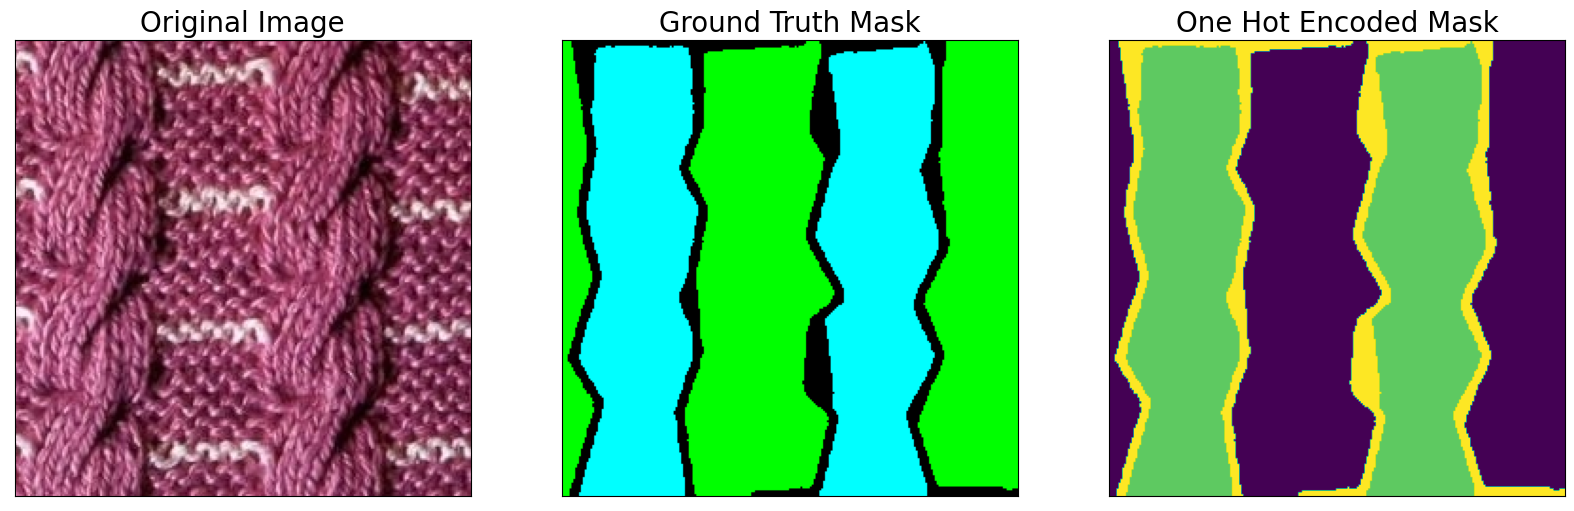

241


In [10]:
# class_values=[0,1,2,3,4,5,6]

dataset = BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[1]
ground_truth_mask=[]
for i in range(len(image)):
  ground_truth_mask.append(colour_code_segmentation(reverse_one_hot(mask)[i], select_class_rgb_values))
visualize(
  original_image = image,
  ground_truth_mask=ground_truth_mask,
  # ground_truth_mask=colour_code_segmentation(reverse_one_hot(mask), class_values),
  one_hot_encoded_mask = reverse_one_hot(mask)
)
print(len(ground_truth_mask))

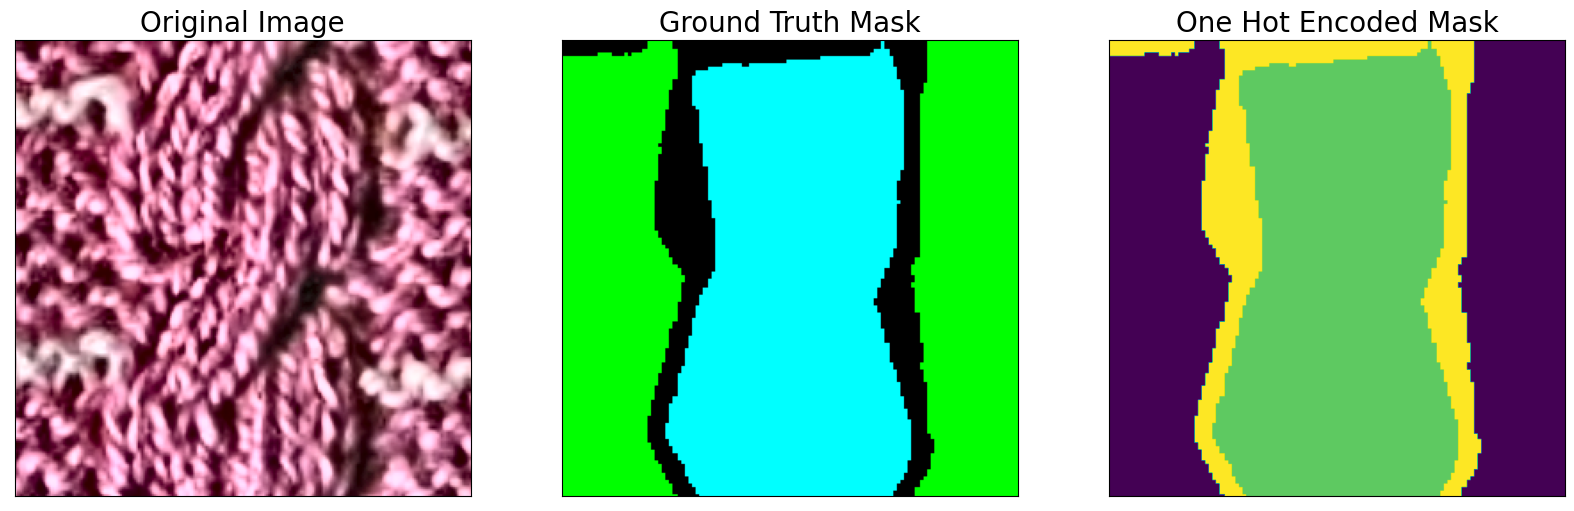

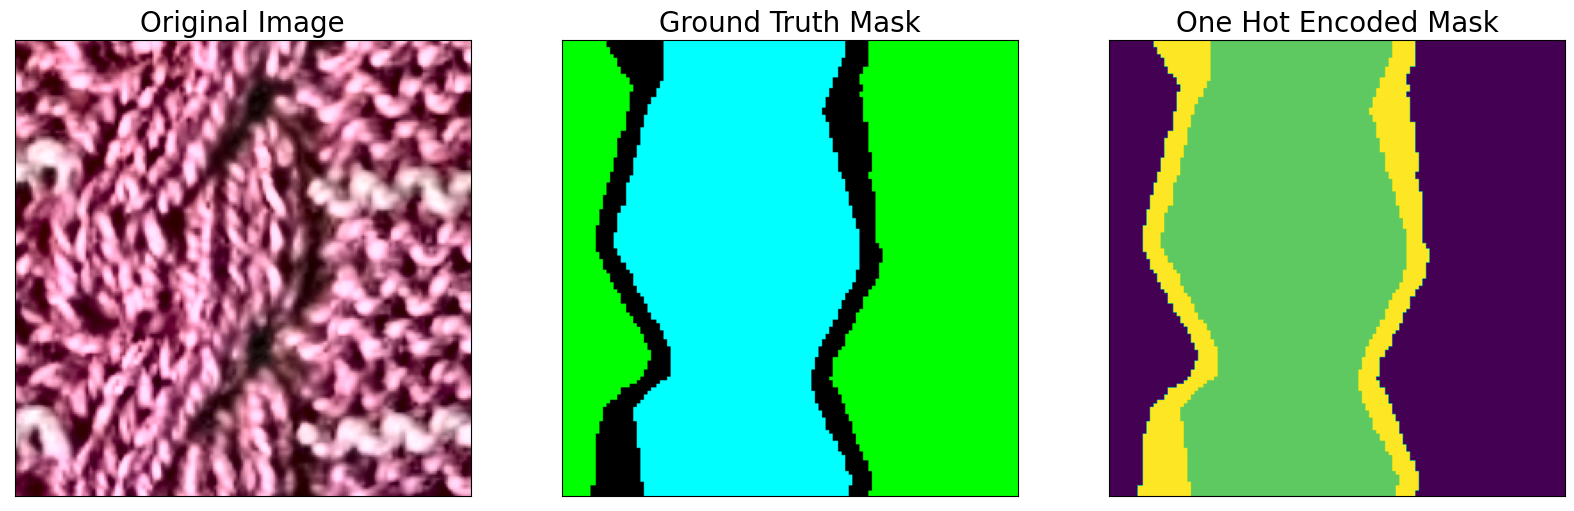

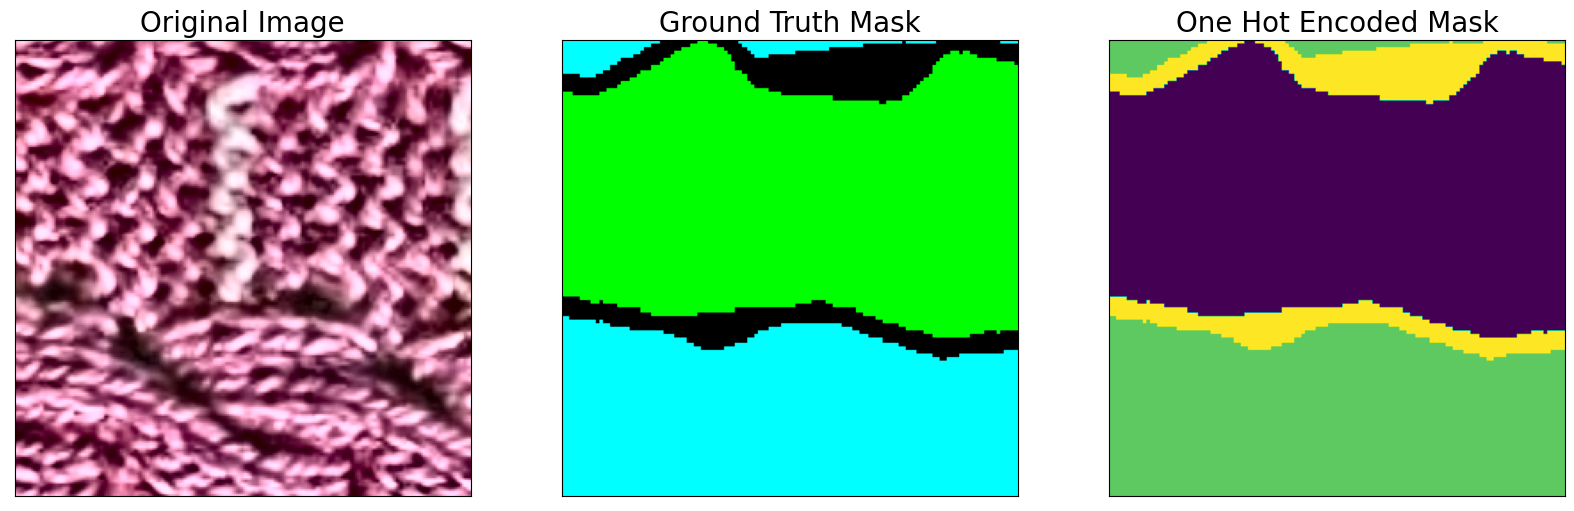

In [11]:
augmented_dataset = BuildingsDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(), ###
    augmentation_img=get_training_color_augmentation(),
    class_rgb_values=select_class_rgb_values
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

In [12]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['type1','type2','type3','type4','type5','type6','background']
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [13]:
train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    # augmentation_img=get_training_color_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)
valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir,
    augmentation=get_training_augmentation(),
    # augmentation_img=get_training_color_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
if __name__ == "__main__":
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
    valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=0)

In [14]:
from segmentation_models_pytorch import utils

# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 5

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# # load best saved model checkpoint from previous commit (if present)
# if os.path.exists('../input/deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth'):
#     model = torch.load('../input/deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth', map_location=DEVICE)

In [15]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [16]:
%%time

if TRAINING:
    model.train()
    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 3/3 [00:00<00:00,  5.29it/s, dice_loss - 0.8553, iou_score - 7.629e-13]
Model saved!

Epoch: 1
valid: 100%|██████████| 3/3 [00:00<00:00,  5.32it/s, dice_loss - 0.8524, iou_score - 7.629e-13]

Epoch: 2
valid: 100%|██████████| 3/3 [00:00<00:00,  5.41it/s, dice_loss - 0.8494, iou_score - 7.629e-13]

Epoch: 3
valid: 100%|██████████| 3/3 [00:00<00:00,  5.26it/s, dice_loss - 0.8426, iou_score - 7.629e-13]

Epoch: 4
valid: 100%|██████████| 3/3 [00:00<00:00,  5.22it/s, dice_loss - 0.8286, iou_score - 0.005015]
Model saved!
Wall time: 45.5 s


In [17]:
# load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')
    torch.save(best_model,"./DeepLabV3_besth_model.pth")

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('./DeepLabV3_besth_model.pth'):
    best_model = torch.load('./DeepLabV3_besth_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from a previous commit.')

Loaded DeepLabV3+ model from this run.


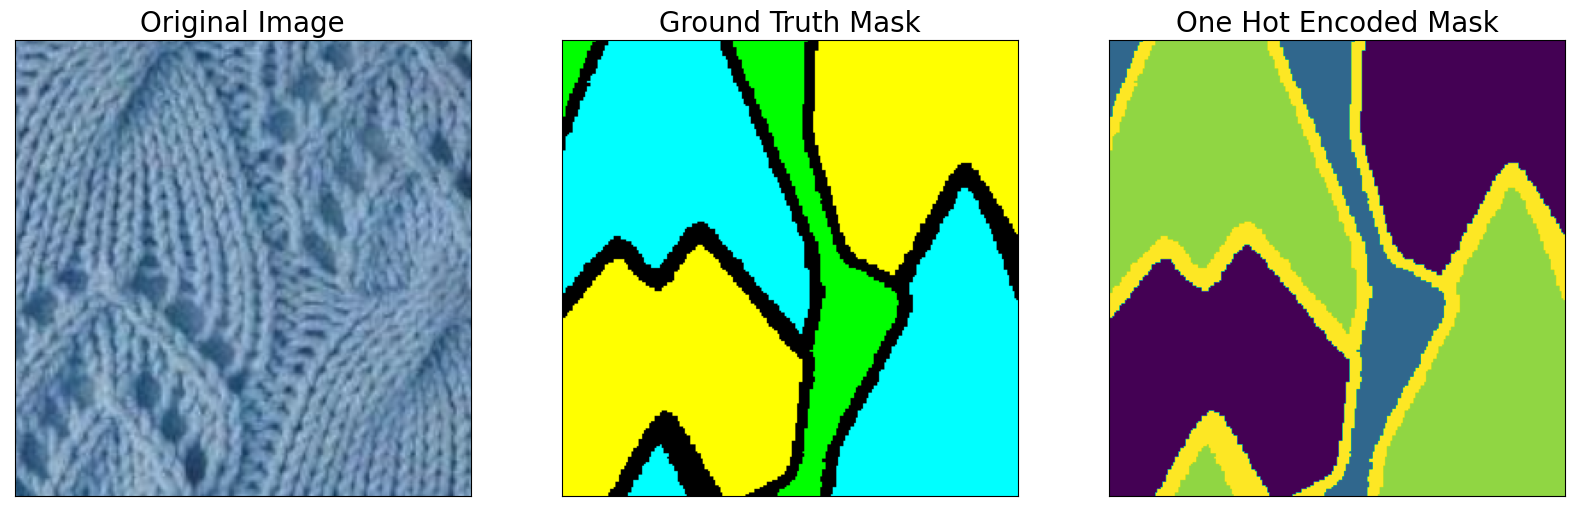

16


In [18]:
# create test dataloader (with preprocessing operation: to_tensor(...))
test_dataset = BuildingsDataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_training_augmentation(),
    # preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = BuildingsDataset(
    x_test_dir, y_test_dir,
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)
print(random_idx)

In [19]:
# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[256,256,3]):

    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [20]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

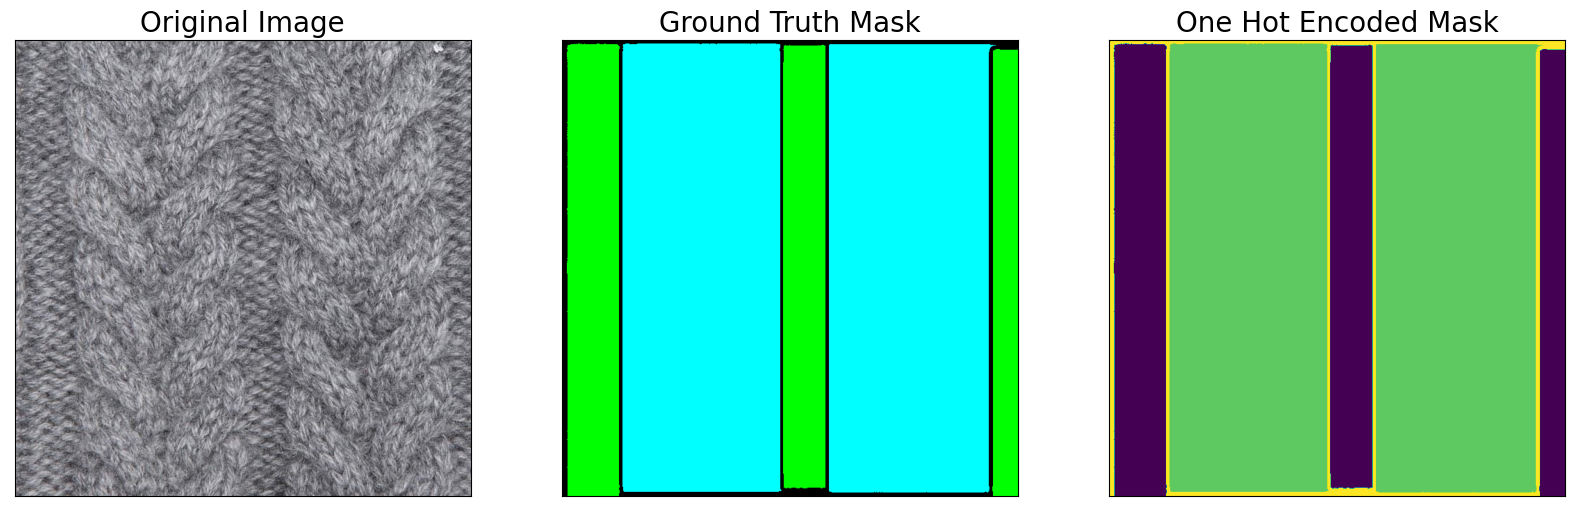

In [21]:
import numpy as np
import cv2
import albumentations as album
import matplotlib.pyplot as plt
import os
import random
import torch

def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20, 8))

    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(name.replace('_', ' ').title(), fontsize=20)
        if name == "ground_truth_mask":
            plt.imshow(image)
        else:
            plt.imshow(image)
    plt.show()

def one_hot_encode(label, label_values):
    label = label.astype(int)
    semantic_map = []

    for colour in label_values[:-1]:
        distance = np.linalg.norm(label - np.array(colour), axis=-1)
        class_map = distance <= 35
        semantic_map.append(class_map)

    labeled_area = np.any(semantic_map, axis=0)
    unlabeled_area = ~labeled_area
    semantic_map.append(unlabeled_area)

    return np.stack(semantic_map, axis=-1)

def reverse_one_hot(image):
    return np.argmax(image, axis=-1)

def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    return colour_codes[image]

class BuildingsDataset(torch.utils.data.Dataset):

    def __init__(self, images_dir, masks_dir, class_rgb_values=None,
                 augmentation=None, augmentation_img=None, preprocessing=None):
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, mask_id) for mask_id in sorted(os.listdir(masks_dir))]
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.augmentation_img = augmentation_img
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        if self.augmentation:
            sample1 = self.augmentation(image=image, mask=mask)
            image, mask = sample1['image'], sample1['mask']
            if self.augmentation_img:
                sample2 = self.augmentation_img(image=image, mask=mask)
                image = sample2['image']
        elif self.augmentation_img:
            sample2 = self.augmentation_img(image=image, mask=mask)
            image = sample2['image']

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.image_paths)

# Augmentation
def get_training_augmentation():
    train_transform = [
        album.Resize(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
        album.OneOf(
            [
                album.CLAHE(clip_limit=(1, 15)),
            ],
            p=1,
        ),
    ]
    return album.Compose(train_transform)

def get_validation_augmentation():
    test_transform = [
        album.Resize(height=256, width=256, always_apply=True),  # 검증 데이터도 동일하게 리사이즈
        album.RandomCrop(height=256, width=256, always_apply=True),
    ]
    return album.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

# Example
dataset = BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset) - 1)
image, mask = dataset[random_idx]

ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values)
visualize(
    original_image=image,
    ground_truth_mask=ground_truth_mask,
    one_hot_encoded_mask=reverse_one_hot(mask)
)


이 밑 셀 수정함

-----

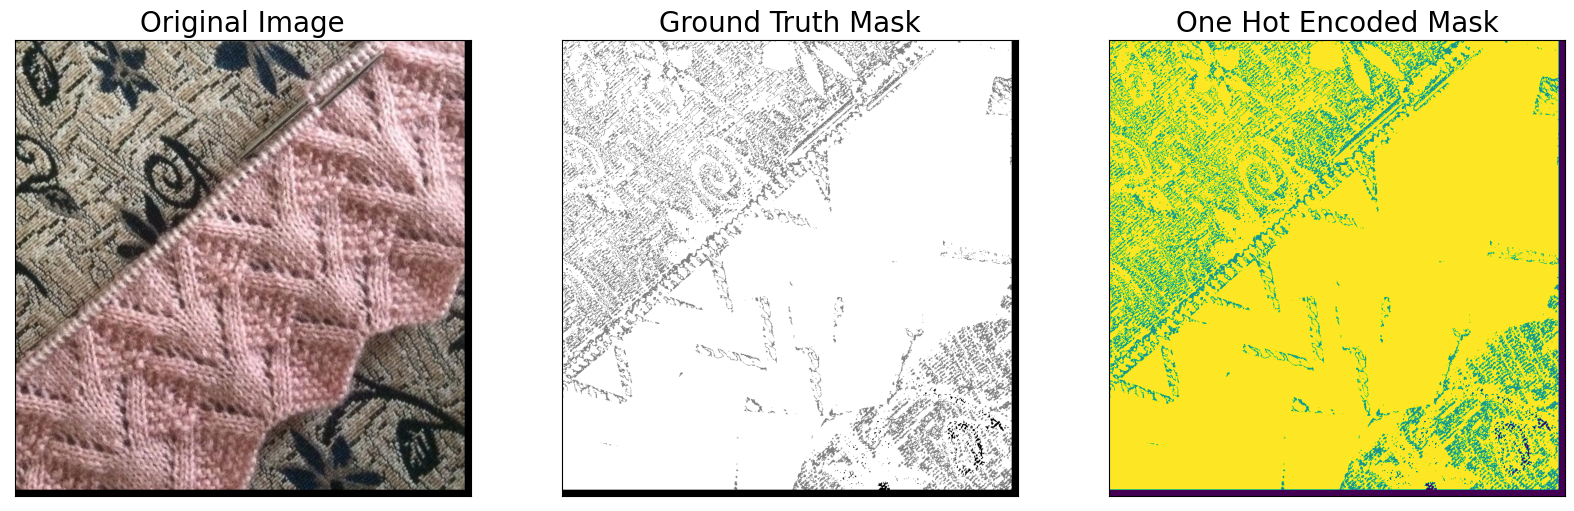

In [119]:
import numpy as np
import cv2
import os
import torch
import random
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import pandas as pd

def one_hot_encode(label, label_values):
    label = label.astype(int)
    semantic_map = []

    for colour in label_values[:-1]:
        distance = np.linalg.norm(label - np.array(colour), axis=-1)
        class_map = distance <= 35
        semantic_map.append(class_map)

    labeled_area = np.any(semantic_map, axis=0)
    unlabeled_area = ~labeled_area
    semantic_map.append(unlabeled_area)

    return np.stack(semantic_map, axis=-1)

def reverse_one_hot(image):
    return np.argmax(image, axis=-1)

def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    return colour_codes[image]

class BuildingsDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, masks_dir, class_rgb_values=None, preprocessing=None):
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, mask_id) for mask_id in sorted(os.listdir(masks_dir))]
        self.class_rgb_values = class_rgb_values
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        image = self.resize_to_multiple_of_16(image)
        mask = self.resize_to_multiple_of_16(mask)

        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def resize_to_multiple_of_16(self, img):
        height, width = img.shape[:2]

        new_height = (height // 16) * 16
        new_width = (width // 16) * 16

        if new_height < height:
            new_height += 16
        if new_width < width:
            new_width += 16

        pad_height = new_height - height
        pad_width = new_width - width

        padded_img = cv2.copyMakeBorder(img, 0, pad_height, 0, pad_width, cv2.BORDER_CONSTANT, value=[0, 0, 0])

        return padded_img

    def __len__(self):
        return len(self.image_paths)

def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20, 8))

    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]), plt.yticks([]) 
        plt.title(name.replace('_', ' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Example
dataset = BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset) - 1)
image, mask = dataset[random_idx]

ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values)
visualize(
    original_image=image,
    ground_truth_mask=ground_truth_mask,
    one_hot_encoded_mask=reverse_one_hot(mask)
)

In [125]:
# Evaluation
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

# Test evaluation
valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid:   0%|          | 0/19 [00:00<?, ?it/s]


RuntimeError: Wrong input shape height=256, width=3. Expected image height and width divisible by 16. Consider pad your images to shape (256, 16).

In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)

train_logs_df.T

# IoU Score graph
plt.figure(figsize=(20, 8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label='Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label='Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

# Dice Loss graph
plt.figure(figsize=(20, 8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label='Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label='Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()